## Objectives

This notebook details the process to detect outliers in one time series data using the time series decomposition method.
- Input: a csv file that contains data with three columns of Account (account id), Month (calendar month), Value (numerical column to detect outliers from); There can be data for multiple accounts in the csv file
- Output: visualizations of outliers detected via STL decomposition and multiple outlier detection methods 

## System Setup and Input

1. This notebook includes R codes and we will need the following R packages:
    - "tidyverse" package for data manipulation
    - "Anomalize" package for STL time series decomposition
    - "ggQC" package for drawing of XmR charts
2. We are using one individual account for demo purpose.

## Load R packages

In [1]:
library(tidyverse)
library(anomalize)
library(ggQC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Read in Data

In [2]:
# read in the csv file which contains the prorated and imputed KWH_Consumption data for NYCHA accounts
tb_all = read_csv("../output/nycha/NYCHA_TS.csv")

# filter out unnecessary columns
tb_all = select(tb_all, c('Account', 'Month', 'Value'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Account = col_character(),
  Month = col_date(format = ""),
  Value = col_double()
)


### Get the list of accounts in the input file

In [3]:
accounts = tb_all %>% group_by(Account) 
accounts <- accounts %>% summarise(counts = n(), na_counts = sum(is.na(Value)))
accounts <- mutate(accounts, na_perc = na_counts/counts)

### Fill the missing values in the "Value" column with 0

The R Anomalize package requires the no missing value in the input dataframe

In [4]:
tb_all <- mutate(tb_all, Value = ifelse(is.na(Value), 0, Value))

## Demo
### Select one account as an example to detect and visualize the outliers

In [5]:
i = match('165.0 - BLD 03_90327795', accounts$Account)

### Apply STL decomposition to the time series

In [6]:
ts = select(filter(tb_all, Account == accounts$Account[[i]]), 'Month', 'Value')

# apply STL decomposition
ts_anomalized <- ts %>%
    time_decompose(Value, method = 'stl', merge = TRUE) 


Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [7]:
# add account info to the tibble
ts_anomalized$Account = accounts$Account[[i]]

# add indicator column of whether the value is missing for a month
ts_anomalized$Missing_Value = ts_anomalized$Value == 0

ts_anomalized <- rename(ts_anomalized, Calendar_Month = Month)
ts_anomalized <- ts_anomalized[, c('Account', 'Calendar_Month', 'Missing_Value', 'observed', 'trend', 'season', 'remainder')]

In [8]:
iqr_3X <- ts_anomalized %>%
        anomalize(remainder, method = 'iqr', alpha = 0.05) %>%
        time_recompose()

### Visualize the outliers detected using the Inter Quartile Range (IQR) method with 3X threshold
Values beyond 3 times of the interquartile range from the 75th and 25th percentiles are considered as outliers.

#### Plot the total value and all three components over time, highlighting the outlier points in red dots and circles

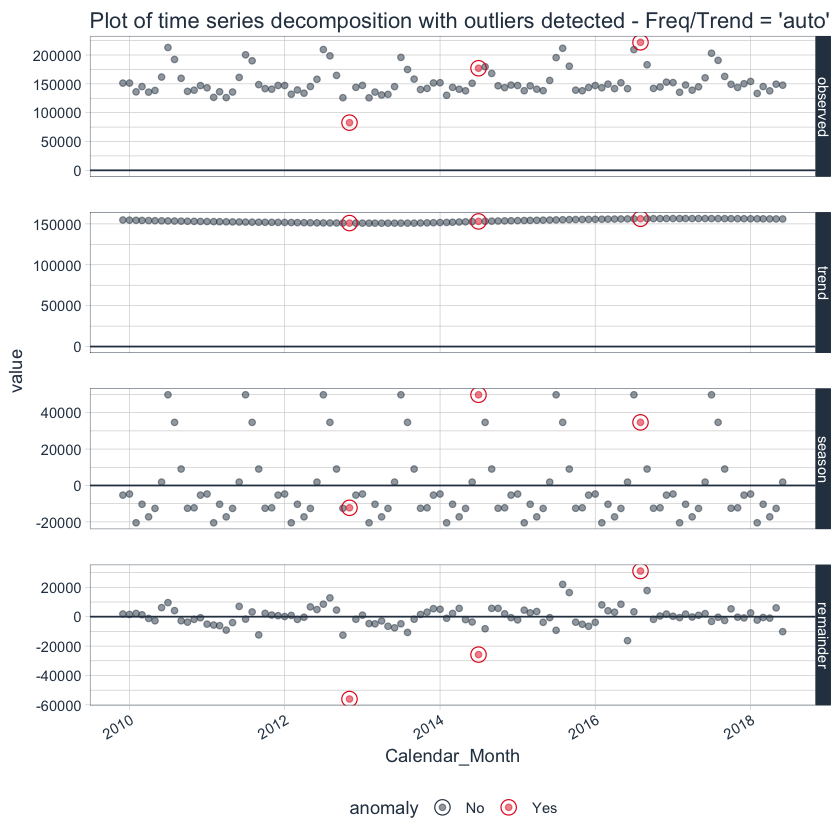

In [9]:
p1 <- iqr_3X %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Plot of time series decomposition with outliers detected - Freq/Trend = 'auto'")

p1

#### plotting configuration of the residual plots that highlights detected outliers

In [10]:
# define a ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

#### Outlier Plot - IQR 3X

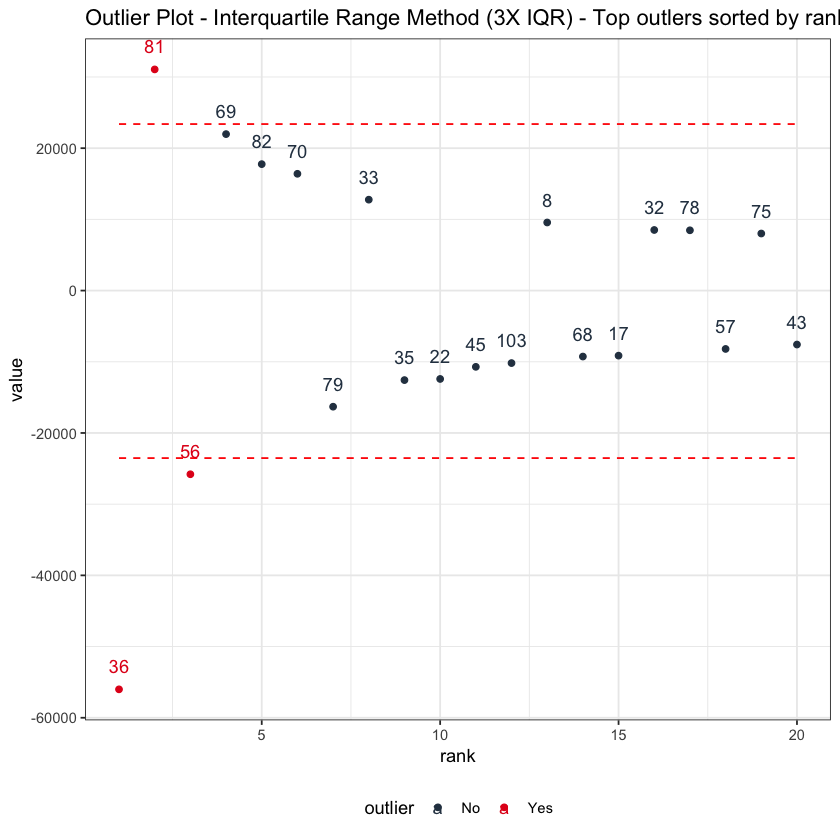

In [11]:
outliers <- iqr(ts_anomalized$remainder, verbose = TRUE, alpha = 0.05)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Outlier Plot - Interquartile Range Method (3X IQR) - Top outlers sorted by rank") 

### Visualize the outliers detected using the Inter Quantile Range (IQR) method with 6X threshold
- residual values beyond 6 times the interquartile range from the 75th and 25th percentiles are considered as outliers

In [12]:
# Calculate residuals
iqr_6X <- ts_anomalized %>%
        anomalize(remainder, method = 'iqr', alpha = 0.025) %>%
        time_recompose()

#### Plot the total value and all three components over time, with the outlier points highlighted in red circles

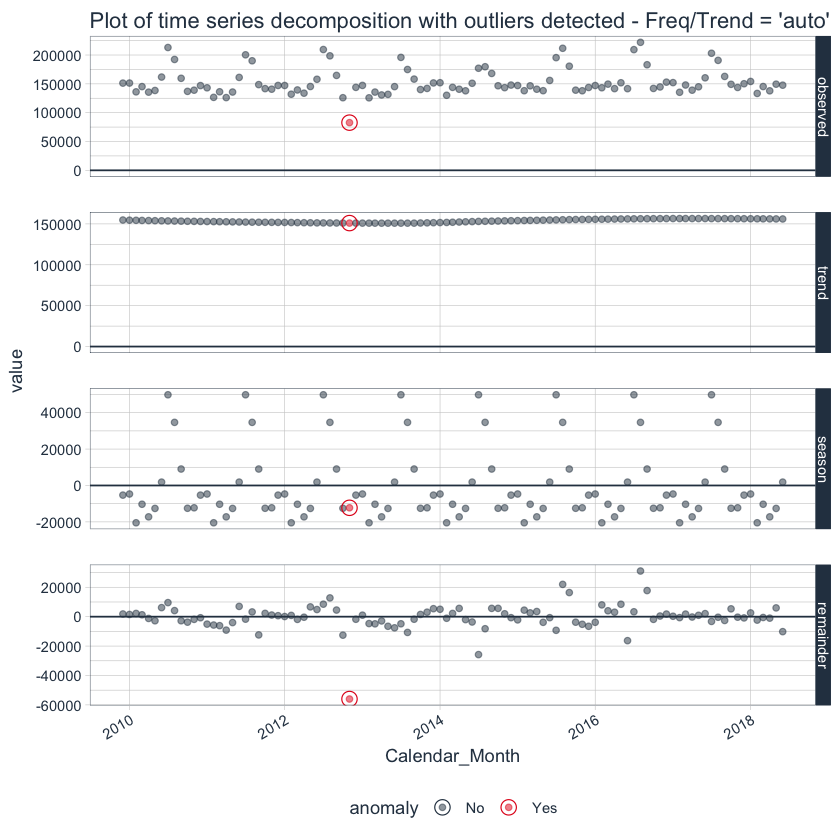

In [13]:
p2 <- iqr_6X %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Plot of time series decomposition with outliers detected - Freq/Trend = 'auto'")

p2

#### Outlier Plot - IQR 6X

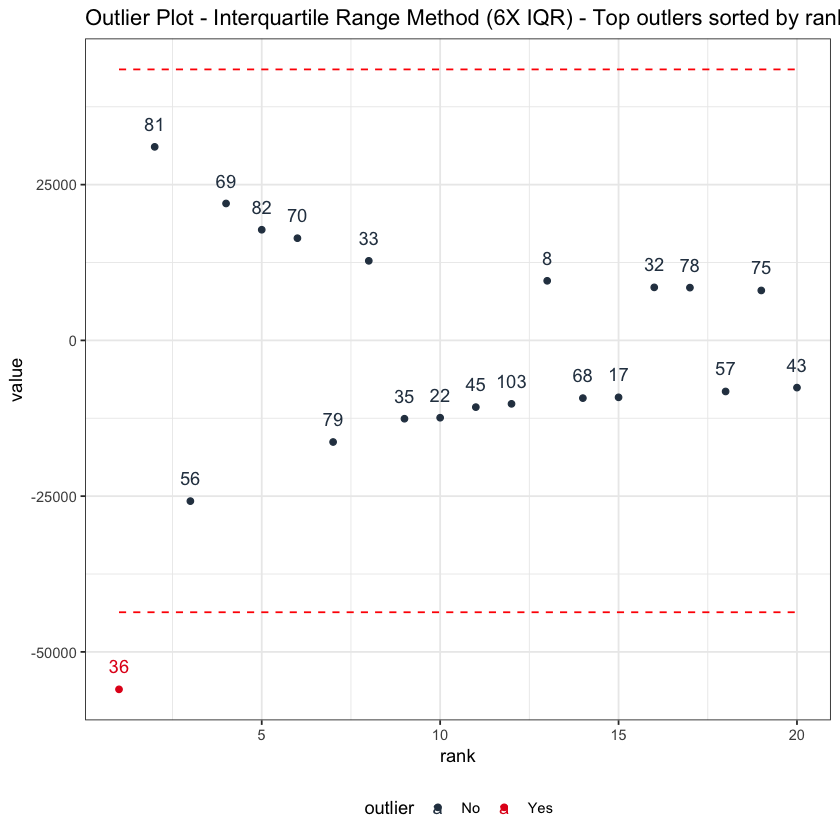

In [14]:
outliers <- iqr(ts_anomalized$remainder, verbose = TRUE, alpha = 0.025)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Outlier Plot - Interquartile Range Method (6X IQR) - Top outlers sorted by rank") 

### Visualize the outliers detected using the XmR (Individual & Moving-Range) chart

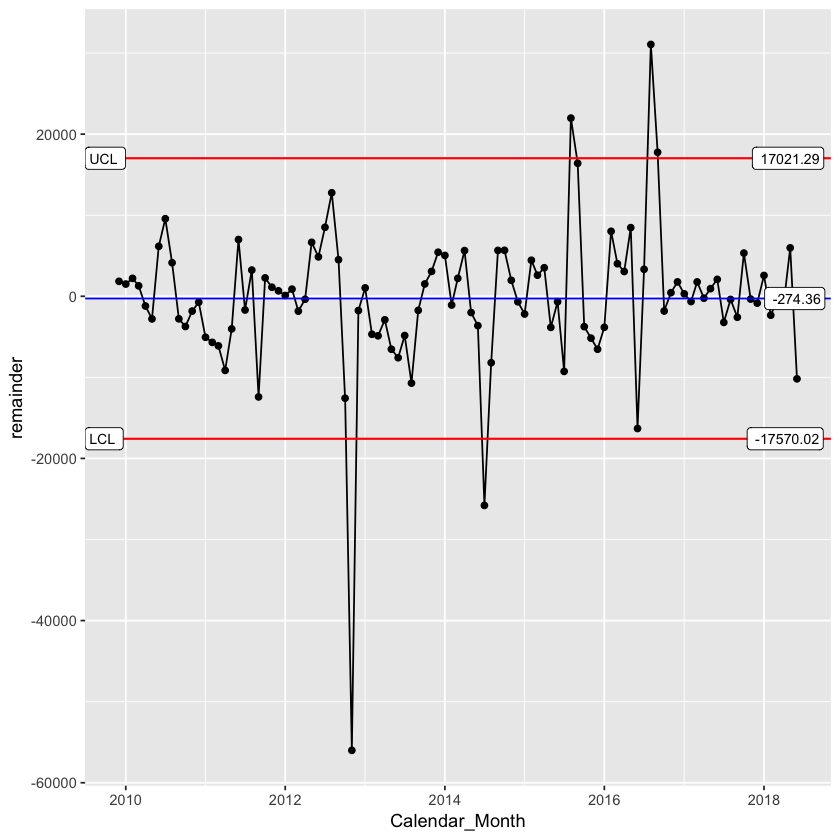

In [15]:
x_Plot <- ggplot(ts_anomalized, aes(x = Calendar_Month, y = remainder)) + geom_point() + geom_line() + 
  stat_QC(method = 'XmR', auto.label = T, label.digits = 2, show.1n2.sigma = F) 
x_Plot

### Assign ranking to the outliers detected

#### Define a function to calculate the deviation of a residual value from the limit values

In [16]:
cal_dev <- function(residual, upper, lower) {
  if (residual < lower) {
    return(lower - residual)
  } else if (residual > upper) {
    return(residual - upper)
  } else {
    return (NA)
  }
}

#### Lable and rank the outliers detected from the 3 methods and save the results in 3 tibbles seprately

In [17]:
iqr_3X <- iqr_3X[, c('Account', 'Calendar_Month', 'remainder', 'remainder_l1', 'remainder_l2', 'anomaly')]

# Add outlier indicator
iqr_3X <- rename(iqr_3X, Residual = remainder, Lower = remainder_l1, Upper = remainder_l2, Anomaly = anomaly)
iqr_3X <- mutate(iqr_3X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

# Calculate deviation from limit
iqr_3X$Dev <- mapply(cal_dev, iqr_3X$Residual, iqr_3X$Upper, iqr_3X$Lower)
iqr_3X <- arrange(iqr_3X, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
iqr_3X$Rank = seq(1:nrow(iqr_3X))
iqr_3X[is.na(iqr_3X$Dev), ]$Rank <- NA

In [18]:
iqr_6X <- iqr_6X[, c('Account', 'Calendar_Month', 'remainder', 'remainder_l1', 'remainder_l2', 'anomaly')]
iqr_6X <- rename(iqr_6X, Residual = remainder, Lower = remainder_l1, Upper = remainder_l2, Anomaly = anomaly)

# Add outlier indicator
iqr_6X <- mutate(iqr_6X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

# Calculate deviation from limit
iqr_6X$Dev <- mapply(cal_dev, iqr_6X$Residual, iqr_6X$Upper, iqr_6X$Lower)
iqr_6X <- arrange(iqr_6X, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
iqr_6X$Rank = seq(1:nrow(iqr_6X))
iqr_6X[is.na(iqr_6X$Dev), ]$Rank <- NA

In [19]:
ctrl_limits <- QC_Lines(data = ts_anomalized$remainder, method = "XmR")  
ctrl_limits <- ctrl_limits[, c('xBar_one_LCL', 'xBar_one_UCL')]
ctrl_limits <- rename(ctrl_limits, Lower= xBar_one_LCL, Upper = xBar_one_UCL)
xmr_mean <- cbind(ts_anomalized[, c('Account', 'Calendar_Month', 'remainder')], ctrl_limits)
xmr_mean <- rename(xmr_mean, Residual = remainder)

# Calculate deviation from limit
xmr_mean$Dev <- mapply(cal_dev, xmr_mean$Residual, xmr_mean$Upper, xmr_mean$Lower)
xmr_mean <- arrange(xmr_mean, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
xmr_mean$Rank = seq(1:nrow(xmr_mean))
xmr_mean[is.na(xmr_mean$Dev), ]$Rank <- NA

# Add outlier indicator
xmr_mean <- mutate(xmr_mean, Anomaly = ifelse(is.na(Dev), FALSE, TRUE))

In [20]:
# rename the columns
iqr_3X <- rename(iqr_3X, Lower_3X = Lower, Upper_3X = Upper, Anomaly_3X = Anomaly, Dev_3X = Dev, Rank_3X = Rank)
iqr_6X <- rename(iqr_6X, Lower_6X = Lower, Upper_6X = Upper, Anomaly_6X = Anomaly, Dev_6X = Dev, Rank_6X = Rank)
xmr_mean <- rename(xmr_mean, Lower_xmr = Lower, Upper_xmr = Upper, Anomaly_xmr = Anomaly, Dev_xmr = Dev, Rank_xmr = Rank)

ts_anomalized <- rename(ts_anomalized, Total = observed, Trend = trend, Seasonal = season
   , Residual = remainder)
ts_anomalized <- ts_anomalized[, c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')]

#### Combine the results of 3 methods to get a final tibble named "result"

In [21]:
result <- 
ts_anomalized[c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')] %>% 
    inner_join(iqr_3X[, -3], by = c('Account', 'Calendar_Month')) %>%
    inner_join(iqr_6X[, -3], by = c('Account', 'Calendar_Month')) %>%
    inner_join(xmr_mean[, -3], by = c('Account', 'Calendar_Month')) 

# considered as an outlier if 
#     1) STL_6X outputs it as an outliers OR
#     2) STL_6X outputs it as a normal point but both other two methods output it as an outlier
result <- mutate(result
    , Anomaly = ifelse(((Anomaly_6X == TRUE) | ((Anomaly_6X == FALSE) & (Anomaly_xmr == TRUE & Anomaly_3X == TRUE))), TRUE, FALSE)
)

# weighted rank of the outlier
result <- 
    mutate(result, Rank = ifelse(is.na(Rank_6X), (Rank_3X + Rank_xmr)/2, Rank_6X))

In [22]:
result <- rename(result, Value = Total, Month = Calendar_Month)

In [23]:
select(arrange(filter(result, !is.na(Rank)), Rank), c('Account', 'Month', 'Value', 'Anomaly', 'Rank'))

Account,Month,Value,Anomaly,Rank
165.0 - BLD 03_90327795,2012-11-01,82710.3,TRUE,1
165.0 - BLD 03_90327795,2016-08-01,222030.0,TRUE,2
165.0 - BLD 03_90327795,2014-07-01,177073.8,TRUE,3
